In [19]:
import pandas as pd
import os
import fnmatch
import numpy as np
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import files

In [2]:
!gdown --id  1raUNfghYhlfAgQHPQs7Jm1BO5WIf01t3  --output "cnn.pth" 

Downloading...
From: https://drive.google.com/uc?id=1raUNfghYhlfAgQHPQs7Jm1BO5WIf01t3
To: /content/cnn.pth
100% 16.7M/16.7M [00:00<00:00, 45.8MB/s]


In [3]:
!gdown --id  1WHJvZs1X1rudeHQANKsy3sQK1WMaZG2i  --output "T.zip" 


Downloading...
From: https://drive.google.com/uc?id=1WHJvZs1X1rudeHQANKsy3sQK1WMaZG2i
To: /content/T.zip
100% 459k/459k [00:00<00:00, 3.52MB/s]


In [4]:
!unzip T.zip

Archive:  T.zip
   creating: T/
  inflating: __MACOSX/._T            
  inflating: T/A1.jpg                
  inflating: __MACOSX/T/._A1.jpg     
  inflating: T/.DS_Store             
  inflating: __MACOSX/T/._.DS_Store  
  inflating: T/E1.jpg                
  inflating: __MACOSX/T/._E1.jpg     
  inflating: T/D1.jpg                
  inflating: __MACOSX/T/._D1.jpg     
  inflating: T/C1.jpg                
  inflating: __MACOSX/T/._C1.jpg     
  inflating: T/G.C.C.jpg             
  inflating: __MACOSX/T/._G.C.C.jpg  
  inflating: T/G.C.B.jpg             
  inflating: __MACOSX/T/._G.C.B.jpg  
  inflating: T/G.C.A.jpg             
  inflating: __MACOSX/T/._G.C.A.jpg  
  inflating: T/G.C.E.jpg             
  inflating: __MACOSX/T/._G.C.E.jpg  
  inflating: T/G.C.D.jpg             
  inflating: __MACOSX/T/._G.C.D.jpg  
  inflating: T/B1.jpg                
  inflating: __MACOSX/T/._B1.jpg     


In [5]:
parent_dir = '/content'
path = os.path.join(parent_dir, 'test')
os.mkdir(path) 


In [6]:
shutil.move('/content/T', '/content/test')


'/content/test/T'

In [7]:
data_dir = '/content/test'
classes = ('A', 'B', 'C', 'D', 'E')
val_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((40, 40), scale=(0.8, 1.0), 
            ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    # transforms.Normalize()
])
val_ds = datasets.ImageFolder(data_dir, val_transforms)

In [8]:
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=10, 
        shuffle=False, drop_last=False, num_workers=2)

In [9]:
for images, labels in val_loader:
    pass

# Get one batch
images, labels = next(iter(val_loader))
images.shape  # Output: torch.Size([30, 3, 500, 500])    [how many images, kernel(rgb), width, length]

torch.Size([10, 3, 40, 40])

In [10]:
def validation(testdata_loader, device=torch.device("cpu")):

  net.eval()


  with torch.no_grad():
    for data in testdata_loader:
      images, labels = data

      outputs = net(images.to(device))
      _, predicted = torch.max(outputs.data.detach().cpu(), 1)
      return predicted


In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes: int = 5, 
                 dropout: float = 0.5) -> None:
        super().__init__()
        
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3)) 
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html


        self.classifier = nn.Sequential(
            # nn.Dropout(p=dropout), # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes), 
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution, 
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)



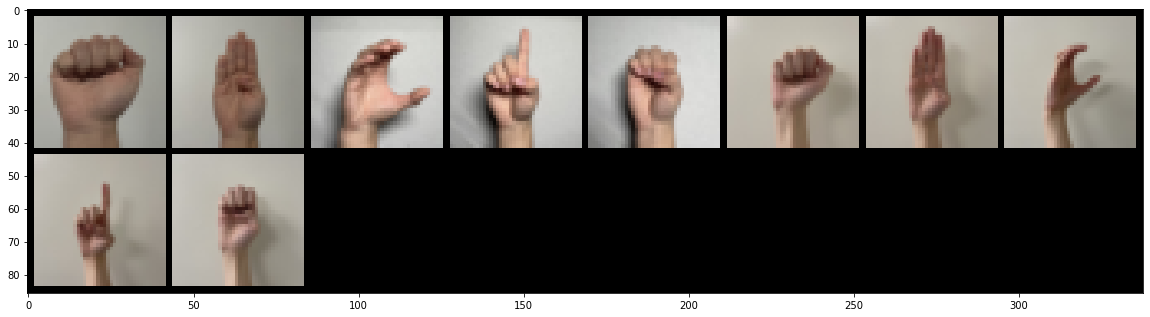

In [12]:
def imshow(img):

  # img = img / 2 + 0.5
  npimg = img.numpy()
  plt.figure(figsize=(20,20))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()
imshow(torchvision.utils.make_grid(images))

In [13]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = CNN(num_classes=5, dropout=0.5) 
PATH = './cnn.pth'
net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
a = validation(val_loader)

In [14]:
ls = []
result = []
for i in list(a):
  b = i.item()
  if i == 0:
    result.append('A')
  elif i == 1:
    result.append('B')
  elif i == 2:
    result.append('C')
  elif i == 3:
    result.append('D')
  elif i == 4:
    result.append('E')
  ls.append(b)

In [15]:
result

['A', 'B', 'C', 'D', 'E', 'A', 'B', 'C', 'D', 'E']

In [16]:
result_pd = pd.DataFrame(sorted(os.listdir('/content/test/T'))[1:], columns = ['Filename'])
result_pd['Predicted_Label'] = result
result_pd

,Filename,Predicted_Label
0,A1.jpg,A
1,B1.jpg,B
2,C1.jpg,C
3,D1.jpg,D
4,E1.jpg,E
5,G.C.A.jpg,A
6,G.C.B.jpg,B
7,G.C.C.jpg,C
8,G.C.D.jpg,D
9,G.C.E.jpg,E


In [21]:
result_pd.to_csv('result.csv' ,index=False)